In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import orth

# Algo

In [2]:
def get_simplex_affine_space_projector(d):
  A = np.zeros([d,d-1])
  for i in range(d-1):
    A[i,i] = 1.
    A[i+1,i] = -1.
  P = orth(A)
  return P @ P.T

In [3]:
def unit_simplex_projector(y):
  r = len(y)
  y_sorted = np.sort(y)

  def criterion(mu):
    res = np.sum(np.maximum(y_sorted - mu,0))
    return res

  idx = 0
  while criterion(y_sorted[idx]) > 1:
    idx += 1
  if idx == 0:
    mu_opt = (np.sum(y_sorted) - 1) / r
  else:
    mu_opt = (np.sum(y_sorted[idx:]) - 1) / (r - idx)

  y_projected = np.maximum(y - mu_opt, 0)
  return y_projected

In [4]:
class WynerProblemSolver:

  def __init__(self, p_joint, s, n_iters, **params):

    self.p_joint = p_joint
    self.n, self.m = p_joint.shape # support size for X and Y
    self.s = s # support size for W
    self.n_iters = n_iters
    self.lr_init = params['lr_init'] if 'lr_init' in params.keys() else 1e-2
    # beta - resularizer constant
    self.beta_init = params['beta_init'] if 'beta_init' in params.keys() else 1.0
    self.beta_decay_factor = params['beta_decay_factor'] if 'beta_decay_factor' in params.keys() else 2.0
    self.beta_decay_every_iters = params['beta_decay_every_iters'] if 'beta_decay_every_iters' in params.keys() else 100
    self.beta_min = params['beta_min'] if 'beta_min' in params.keys() else 1e-6
    self.tol = params['tol'] if 'tol' in params.keys() else 1e-6 # tolerance in acceptance criterion
    self.eps = params['eps'] if 'eps' in params.keys() else 1e-8 # smoothing const
    self.print_every = params['print_every'] if 'print_every' in params.keys() else None
    # parameter of Dirichlet distribution for parameters initialization
    self.alpha = params['alpha'] if 'alpha' in params.keys() else 1
    self.loss_type = params['loss_type'] if 'loss_type' in params.keys() else 'mle'
    assert self.loss_type in ['mle', 'l2'] # Maximum likelyhood estimator and l2-norm loss
    self.optim = params['optim'] if 'optim' in params.keys() else 'GD'
    # GD - Gradient descent, LD - Langevin Dynamics, reLD - Replica exchange Langevin dynamics.
    # reLD is not implemented yet
    assert self.optim in ['GD', 'LD', 'reLD']
    self.tau1 = params['tau1'] if 'tau1' in params.keys() else 1 # tempetature for LD and reLD
    self.tau2 = params['tau2'] if 'tau2' in params.keys() else 10 # tempetature for reLD only
    self.tau_decay_factor = params['tau_decay_factor'] if 'tau_decay_factor' in params.keys() else None
    self.vanish_tau_after_iter = params['vanish_tau_after_iter'] if 'vanish_tau_after_iter' in params.keys() else None

    # to be initialized in self.train() method
    self.lambdas = None
    self.X = None
    self.Y = None

    self.lambdas_best = None
    self.X_best = None
    self.Y_best = None
    self.score_best = None

    self.q_joint = None
    self.lr = None

    self.p_joint_entropy = - np.sum(np.where(p_joint != 0,p_joint * np.log(p_joint), 0))

    self.lambdas_affine_projector = get_simplex_affine_space_projector(self.s)
    self.X_affine_projector = get_simplex_affine_space_projector(self.n)
    self.Y_affine_projector = get_simplex_affine_space_projector(self.m)

    self.metrics = {
        'iter': [],
        'lr': []
    }

  def initialize(self):
    self.lambdas = np.random.dirichlet([self.alpha] * self.s)
    assert math.isclose(np.sum(self.lambdas), 1)

    self.X = np.random.dirichlet([self.alpha] * self.n, (self.s,))
    assert np.allclose(self.X.sum(axis=1), 1)

    self.Y = np.random.dirichlet([self.alpha] * self.m, (self.s,))
    assert np.allclose(self.Y.sum(axis=1), 1)

  def eval_MLE_loss(self, *model_params):
    if len(model_params) == 0:
      q_joint = self.q_joint
    else:
      lambdas, X, Y = model_params
      q_joint = X.T @ np.diag(lambdas) @ Y
    res = (-1) * np.sum(self.p_joint * np.log(q_joint+self.eps))
    return res

  def eval_L2_loss(self, *model_params):
    if len(model_params) == 0:
      q_joint = self.q_joint
    else:
      lambdas, X, Y = model_params
      q_joint = X.T @ np.diag(lambdas) @ Y
    res = 0.5 * np.sum(np.square(self.p_joint - q_joint))
    return res

  def eval_D_KL(self, *model_params):
    if len(model_params) == 0:
      q_joint = self.q_joint
    else:
      lambdas, X, Y = model_params
      q_joint = X.T @ np.diag(lambdas) @ Y
    res = (-1) * np.sum(np.where(self.p_joint != 0, self.p_joint * np.log(q_joint), 0)) - self.p_joint_entropy
    return res

  def eval_objective_loss(self, *model_params):
    if len(model_params) == 0:
      lambdas, X, Y = self.lambdas, self.X, self.Y
    else:
      lambdas, X, Y = model_params
    res = np.sum(lambdas * (np.sum(X * np.log(X+self.eps), axis=1) + np.sum(Y * np.log(Y+self.eps), axis=1)))
    return res

  def eval_constraint_loss(self, *model_params):
    res = self.eval_MLE_loss(*model_params) if self.loss_type == 'mle' else self.eval_L2_loss(*model_params)
    return res

  def eval_final_objective(self, *model_params):
    res = self.eval_constraint_loss(*model_params) + self.beta_min * self.eval_objective_loss(*model_params)
    return res

  def eval_distribution_proximity(self, *model_params):
    res = self.eval_D_KL(*model_params) if self.loss_type == 'mle' else self.eval_L2_loss(*model_params)
    return res

  def eval_MLE_grads(self, *model_params):
    if len(model_params) == 0:
      lambdas, X, Y = self.lambdas, self.X, self.Y
      q_joint = self.q_joint
    else:
      lambdas, X, Y = model_params
      q_joint = X.T @ np.diag(lambdas) @ Y
    p_div_q = self.p_joint / (q_joint + self.eps)
    lambdas_grad = (-1) * np.sum(p_div_q * (X.reshape(self.s,self.n,1) * Y.reshape(self.s,1,self.m)), axis=(1,2))
    X_grad = (-1) * np.sum(p_div_q.reshape(1,self.n,self.m) * (lambdas.reshape(self.s,1) * Y).reshape(self.s,1,self.m), axis=2)
    Y_grad = (-1) * np.sum(p_div_q.reshape(1,self.n,self.m) * (lambdas.reshape(self.s,1) * X).reshape(self.s,self.n,1), axis=1)
    return lambdas_grad, X_grad, Y_grad

  def eval_L2_grads(self, *model_params):
    if len(model_params) == 0:
      lambdas, X, Y = self.lambdas, self.X, self.Y
      q_joint = self.q_joint
    else:
      lambdas, X, Y = model_params
      q_joint = X.T @ np.diag(lambdas) @ Y
    lambdas_grad = np.sum((q_joint - self.p_joint) * (X.reshape(self.s,self.n,1) * Y.reshape(self.s,1,self.m)), axis=(1,2))
    X_grad = np.sum((q_joint - self.p_joint).reshape(1,self.n,self.m) * (lambdas.reshape(self.s,1) * Y).reshape(self.s,1,self.m), axis=2)
    Y_grad = np.sum((q_joint - self.p_joint).reshape(1,self.n,self.m) * (lambdas.reshape(self.s,1) * X).reshape(self.s,self.n,1), axis=1)
    return lambdas_grad, X_grad, Y_grad

  def eval_objective_grads(self, *model_params):
    if len(model_params) == 0:
      lambdas, X, Y = self.lambdas, self.X, self.Y
    else:
      lambdas, X, Y = model_params
    lambdas_grad = (np.sum(X * np.log(X + self.eps), axis=1) + np.sum(Y * np.log(Y + self.eps), axis=1))
    X_grad = lambdas.reshape(self.s,1) * (1 + np.log(X + self.eps))
    Y_grad = lambdas.reshape(self.s,1) * (1 + np.log(Y + self.eps))
    return lambdas_grad, X_grad, Y_grad

  def eval_constraint_grads(self, *model_params):
    res = self.eval_MLE_grads(*model_params) if self.loss_type == 'mle' else self.eval_L2_grads(*model_params)
    return res

  def eval_affine_grad_norm(self, lambdas_grad, X_grad, Y_grad):
    lambdas_affine_grad = self.lambdas_affine_projector @ lambdas_grad
    X_affine_grad = (self.X_affine_projector @ X_grad.T).T
    Y_affine_grad = (self.Y_affine_projector @ Y_grad.T).T

    affine_grads = (lambdas_affine_grad, X_affine_grad, Y_affine_grad)
    affine_grad_norm = math.sqrt(sum([np.sum(np.square(g)) for g in affine_grads]))

    return affine_grad_norm

  def gradient_descent_step(self, loss, grads, beta, n_iter):

    grad_norm_squared = sum([np.sum(np.square(g)) for g in grads])
    lambdas_grad, X_grad, Y_grad = grads
    criterion = False

    while not criterion:

      lambdas_next_unprojected = self.lambdas - self.lr * lambdas_grad
      lambdas_next = unit_simplex_projector(lambdas_next_unprojected)

      X_next_unprojected = self.X - self.lr * X_grad
      X_next = np.zeros_like(X_next_unprojected)
      for i in range(s):
        X_next[i] = unit_simplex_projector(X_next_unprojected[i])

      Y_next_unprojected = self.Y - self.lr * Y_grad
      Y_next = np.zeros_like(Y_next_unprojected)
      for i in range(s):
        Y_next[i] = unit_simplex_projector(Y_next_unprojected[i])

      params_next = (lambdas_next, X_next, Y_next)
      params_next_unprojected = (lambdas_next_unprojected, X_next_unprojected, Y_next_unprojected)
      correction_norm_squared = sum([np.sum(np.square(p1-p2)) for p1, p2 in zip(params_next, params_next_unprojected)])

      loss_next = self.eval_constraint_loss(*params_next) + \
                  beta * self.eval_objective_loss(*params_next)

      criterion = loss_next <= loss - (self.lr/2) * grad_norm_squared + 1 / (2*self.lr) * correction_norm_squared + self.tol
      if not criterion:
        self.lr /= 2

    self.metrics['iter'].append(n_iter+1)
    self.metrics['lr'].append(self.lr)

    self.lr *= 2
    return params_next

  def langevin_dynamics_step(self, grads, n_iter):

    lambdas_grad, X_grad, Y_grad = grads

    lambdas_unprojected = self.lambdas - self.lr * lambdas_grad + \
                          math.sqrt(2 * self.lr * self.tau1) * np.random.randn(*self.lambdas.shape)
    lambdas_next = unit_simplex_projector(lambdas_unprojected)

    X_next_unprojected = self.X - self.lr * X_grad + \
                          math.sqrt(2 * self.lr * self.tau1) * np.random.randn(*self.X.shape)
    X_next = np.zeros_like(X_next_unprojected)
    for i in range(s):
      X_next[i] = unit_simplex_projector(X_next_unprojected[i])

    Y_next_unprojected = self.Y - self.lr * Y_grad + \
                          math.sqrt(2 * self.lr * self.tau1) * np.random.randn(*self.Y.shape)
    Y_next = np.zeros_like(Y_next_unprojected)
    for i in range(s):
      Y_next[i] = unit_simplex_projector(Y_next_unprojected[i])

    if self.tau_decay_factor is not None:
      self.tau1 /= self.tau_decay_factor

    if (self.vanish_tau_after_iter is not None) and (n_iter+1 == self.vanish_tau_after_iter):
      self.tau1 = 0

    self.metrics['iter'].append(n_iter+1)
    self.metrics['lr'].append(self.lr)

    return lambdas_next, X_next, Y_next

  def print_message(self, n_iter, beta, last_step_size, **params):

    objective_loss = params['objective_loss'] if 'objective_loss' in params.keys() else self.eval_objective_loss()
    disrtibution_proximity = self.eval_distribution_proximity()
    constraint_grads = params['constraint_grads'] if 'constraint_grads' in params.keys() else self.eval_constraint_grads()
    objective_grads = params['objective_grads'] if 'objective_grads' in params.keys() else self.eval_objective_grads()

    constr_affine_grad_norm = self.eval_affine_grad_norm(*constraint_grads)
    objective_afine_grad_norm = self.eval_affine_grad_norm(*objective_grads)

    message = f'{n_iter: <5}: distr proximity = {disrtibution_proximity: .8f}, objective loss = {objective_loss: .6f}, \
consrt_aff_grad = {constr_affine_grad_norm:.6f}, obj_aff_grad = {objective_afine_grad_norm:.6f}, beta = {beta: .8f}'

    if self.optim == 'GD':
      message += f', lr = {self.lr: .6f}'
    else:
      message += f', tau1 = {self.tau1:.8f}'

    if n_iter > 0:
      message += f', step size = {last_step_size:.8f}'

    print(message)

  def train(self):
    self.lr = self.lr_init
    beta = self.beta_init

    self.initialize()

    self.q_joint = self.X.T @ np.diag(self.lambdas) @ self.Y

    self.lambdas_best, self.X_best, self.Y_best = self.lambdas.copy(), self.X.copy(), self.Y.copy()
    self.score_best = self.eval_final_objective()

    last_step_size = None

    for n_iter in range(self.n_iters):

      constraint_loss = self.eval_constraint_loss()
      objective_loss = self.eval_objective_loss()
      loss = constraint_loss + beta * objective_loss

      constraint_grads = self.eval_constraint_grads()
      objective_grads = self.eval_objective_grads()
      grads = [g1 + beta * g2 for g1, g2 in zip(constraint_grads, objective_grads)]

      if (self.print_every is not None) and (n_iter % self.print_every == 0):
        params = {
            'objective_loss': objective_loss,
            'constraint_grads': constraint_grads,
            'objective_grads': objective_grads,
        }
        self.print_message(n_iter, beta, last_step_size, **params)

      if self.optim == 'GD':
        params_next = self.gradient_descent_step(loss, grads, beta, n_iter)
      else:
        params_next = self.langevin_dynamics_step(grads, n_iter)

      params = (self.lambdas, self.X, self.Y)
      last_step_size = math.sqrt(sum([np.sum(np.square(p1-p2)) for p1, p2 in zip(params, params_next)]))
      self.lambdas, self.X, self.Y = params_next

      new_score = self.eval_final_objective()
      if new_score < self.score_best:
        self.score_best = new_score
        self.lambdas_best, self.X_best, self.Y_best = self.lambdas.copy(), self.X.copy(), self.Y.copy()

      assert np.allclose(self.X.sum(axis=1), 1), f'{self.X.sum(axis=1)}'
      assert np.allclose(self.Y.sum(axis=1), 1), f'{self.Y.sum(axis=1)}'
      assert math.isclose(np.sum(self.lambdas), 1), f'{np.sum(self.lambdas)}'

      self.q_joint = self.X.T @ np.diag(self.lambdas) @ self.Y

      if (self.beta_decay_every_iters is not None) and (n_iter % self.beta_decay_every_iters == 0) and (n_iter > 0):
        beta /= self.beta_decay_factor
      if (self.beta_min is not None) and (beta < self.beta_min):
        beta = self.beta_min

    if self.print_every is not None:
      self.print_message(self.n_iters, beta, last_step_size)

    return self.lambdas_best, self.X_best, self.Y_best

# Doubly symmetric bynary sourse

In [5]:
# DSBS test
a0 = 1/3 # crossover prob
a1 = 0.5 * (1 - math.sqrt(1-2*a0))
p_XY = 0.5 * np.array([[1-a0, a0],
                       [a0, 1-a0]])
lambdas_true = np.array([1/2, 1/2])
X_true = np.array([[1-a1, a1],
                   [a1, 1-a1]])
Y_true = np.array([[1-a1, a1],
                   [a1, 1-a1]])
def h(a):
  return - (a * math.log2(a) + (1-a) * math.log2(1-a))

C_XY_true = 1 + h(a0) - 2 * h(a1)

p_XY_entropy = - np.sum(np.where(p_XY != 0,p_XY * np.log2(p_XY), 0))

def evaluate_cond_entropy(lambdas, X, Y):
    q_joint = X.T @ np.diag(lambdas) @ Y
    res = (-1) * np.sum(lambdas * (np.sum(X * np.log2(X), axis=1) + np.sum(Y * np.log2(Y), axis=1)))
    return res

def evaluate_D_KL(lambdas, X, Y, p_joint):
    q_joint = X.T @ np.diag(lambdas) @ Y
    p_joiny_entropy = - np.sum(np.where(p_joint != 0,p_joint * np.log(p_joint), 0))
    res = (-1) * np.sum(np.where(p_joint != 0, p_joint * np.log(q_joint), 0)) - p_joiny_entropy
    return res

with np.printoptions(precision=5):
  print(f'lambdas_true:\n{lambdas_true}')
  print(f'X_true:\n{X_true}')
  print(f'Y_true:\n{Y_true}')

print(f'C(X,Y) = {C_XY_true: .5f}')

lambdas_true:
[0.5 0.5]
X_true:
[[0.78868 0.21132]
 [0.21132 0.78868]]
Y_true:
[[0.78868 0.21132]
 [0.21132 0.78868]]
C(X,Y) =  0.43028


In [6]:
p_joint=p_XY
s=2
n_iters=2500
params = {}
params['lr_init']=0.01
params['beta_init']=1e-1
params['beta_decay_factor']=2
params['beta_decay_every_iters']=100
params['beta_min'] = 1e-7
params['tol']=1e-8
params['eps']=1e-8
params['print_every'] = 100
params['alpha'] = 1
params['loss_type'] = 'l2'
params['optim'] = 'GD'
params['tau1'] = 1
params['tau2'] = 10

solver_GD = WynerProblemSolver(p_joint, s, n_iters, **params)
lambdas, X, Y = solver_GD.train()

cond_entropy = evaluate_cond_entropy(lambdas, X, Y)
C_XY_estim = p_XY_entropy - cond_entropy
print(f'C_XY_estim = {C_XY_estim:.5f}')

0    : distr proximity =  0.06882138, objective loss = -1.033665, consrt_aff_grad = 0.254843, obj_aff_grad = 1.403484, beta =  0.10000000, lr =  0.010000
100  : distr proximity =  0.01384705, objective loss = -1.385791, consrt_aff_grad = 0.001510, obj_aff_grad = 0.016926, beta =  0.10000000, lr =  2.560000, step size = 0.00060974
200  : distr proximity =  0.00554996, objective loss = -1.260274, consrt_aff_grad = 0.025693, obj_aff_grad = 0.513899, beta =  0.05000000, lr =  10.240000, step size = 0.00257083
300  : distr proximity =  0.00147923, objective loss = -1.152337, consrt_aff_grad = 0.018222, obj_aff_grad = 0.728881, beta =  0.02500000, lr =  5.120000, step size = 0.00053022
400  : distr proximity =  0.00038652, objective loss = -1.093985, consrt_aff_grad = 0.010361, obj_aff_grad = 0.828898, beta =  0.01250000, lr =  5.120000, step size = 0.00027001
500  : distr proximity =  0.00009902, objective loss = -1.063284, consrt_aff_grad = 0.005498, obj_aff_grad = 0.879578, beta =  0.0062

In [7]:
p_joint=p_XY
s=2
n_iters=2500
params = {}
params['lr_init']=1
params['beta_init']=1e-1
params['beta_decay_factor']=2
params['beta_decay_every_iters']=100
params['beta_min'] = 1e-7
params['tol']=1e-8
params['eps']=1e-8
params['print_every'] = 100
params['alpha'] = 1
params['loss_type'] = 'l2'
params['optim'] = 'LD'
params['tau1'] = 0
params['tau2'] = 10
params['tau_decay_factor'] = 1.0001
params['vanish_tau_after_iter'] = 16000

solver_LD = WynerProblemSolver(p_joint, s, n_iters, **params)
lambdas, X, Y = solver_LD.train()

cond_entropy = evaluate_cond_entropy(lambdas, X, Y)
C_XY_estim = p_XY_entropy - cond_entropy
print(f'C_XY_estim = {C_XY_estim:.5f}')

0    : distr proximity =  0.02514112, objective loss = -1.103744, consrt_aff_grad = 0.139611, obj_aff_grad = 1.018792, beta =  0.10000000, tau1 = 0.00000000
100  : distr proximity =  0.01370050, objective loss = -1.384022, consrt_aff_grad = 0.005372, obj_aff_grad = 0.063827, beta =  0.10000000, tau1 = 0.00000000, step size = 0.00108117
200  : distr proximity =  0.00636021, objective loss = -1.276128, consrt_aff_grad = 0.025859, obj_aff_grad = 0.478843, beta =  0.05000000, tau1 = 0.00000000, step size = 0.00204200
300  : distr proximity =  0.00148838, objective loss = -1.152160, consrt_aff_grad = 0.018257, obj_aff_grad = 0.730249, beta =  0.02500000, tau1 = 0.00000000, step size = 0.00029205
400  : distr proximity =  0.00038864, objective loss = -1.093553, consrt_aff_grad = 0.010394, obj_aff_grad = 0.831580, beta =  0.01250000, tau1 = 0.00000000, step size = 0.00017211
500  : distr proximity =  0.00009949, objective loss = -1.062787, consrt_aff_grad = 0.005515, obj_aff_grad = 0.882493, 

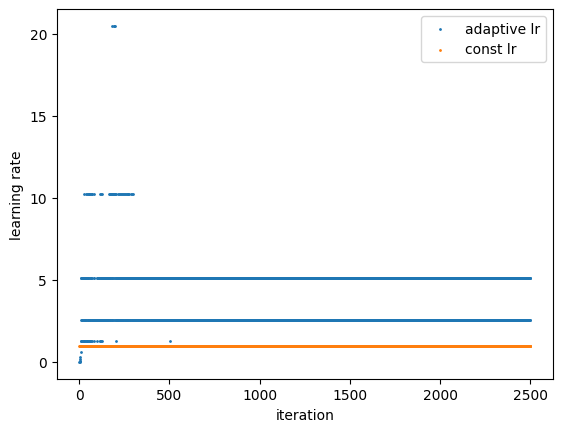

In [ ]:
plt.scatter(solver_GD.metrics['iter'], solver_GD.metrics['lr'], label='adaptive lr', s=1)
plt.scatter(solver_LD.metrics['iter'], solver_LD.metrics['lr'], label='const lr', s=1)

plt.xlabel('iteration')
plt.ylabel('learning rate')
#plt.yscale('log')

plt.legend()
plt.show()

In [ ]:
p_joint=p_XY
s=2
n_iters=2500
params = {}
params['lr_init']=0.01
params['beta_init']=0.1
params['beta_decay_factor']=2
params['beta_decay_every_iters']=100
params['beta_min'] = 1e-7
params['tol']=1e-8
params['eps']=1e-8
params['print_every'] = None
params['alpha'] = 1
params['loss_type'] = 'l2'
params['optim'] = 'GD'
params['tau1'] = 1
params['tau2'] = 10

lambdas_min_GD = []
C_XY_estim_GD = []
proximity_GD = []
for _ in range(50):
  solver_GD = WynerProblemSolver(p_joint, s, n_iters, **params)
  lambdas, X, Y = solver_GD.train()
  lambdas_min_GD.append(lambdas.min())
  cond_entropy = evaluate_cond_entropy(lambdas, X, Y)
  C_XY_estim_GD.append(p_XY_entropy - cond_entropy)
  proximity_GD.append(solver_GD.eval_distribution_proximity(lambdas, X, Y))
  print(f'proximity = {proximity_GD[-1]: .8f}, lambda_min = {lambdas_min_GD[-1]: .5f}, C_XY_estim - C_XY_true = {C_XY_estim_GD[-1] - C_XY_true: .6f}')

proximity =  0.00000000, lambda_min =  0.49527, C_XY_estim - C_XY_true =  0.000014
proximity =  0.00000000, lambda_min =  0.49582, C_XY_estim - C_XY_true =  0.000012
proximity =  0.00000000, lambda_min =  0.49793, C_XY_estim - C_XY_true =  0.000001
proximity =  0.00000000, lambda_min =  0.49899, C_XY_estim - C_XY_true = -0.000000
proximity =  0.00000000, lambda_min =  0.49699, C_XY_estim - C_XY_true =  0.000005
proximity =  0.00000000, lambda_min =  0.49561, C_XY_estim - C_XY_true =  0.000010
proximity =  0.00000000, lambda_min =  0.49779, C_XY_estim - C_XY_true =  0.000003
proximity =  0.00000000, lambda_min =  0.49546, C_XY_estim - C_XY_true =  0.000013
proximity =  0.00000000, lambda_min =  0.49524, C_XY_estim - C_XY_true =  0.000014
proximity =  0.00000000, lambda_min =  0.49801, C_XY_estim - C_XY_true =  0.000002
proximity =  0.00000000, lambda_min =  0.49714, C_XY_estim - C_XY_true =  0.000004
proximity =  0.00000000, lambda_min =  0.49891, C_XY_estim - C_XY_true =  0.000000
prox

In [ ]:
proximity_GD = np.array(proximity_GD)
C_XY_estim_GD = np.array(C_XY_estim_GD)

mask = proximity_GD < 1e-7

recall = np.sum(mask) / len(proximity_GD)
precision = np.mean(C_XY_estim_GD[mask] - C_XY_true)

print(f'precision = {precision:.6f}, recall = {100*recall}%')

precision = 0.000025, recall = 88.0%


In [ ]:
p_joint=p_XY
s=2
n_iters=2500
params = {}
params['lr_init']=0.1
params['beta_init']=1e-1
params['beta_decay_factor']=2
params['beta_decay_every_iters']=100
params['beta_min'] = 1e-7
params['tol']=1e-8
params['eps']=1e-8
params['print_every'] = None
params['alpha'] = 1
params['loss_type'] = 'l2'
params['optim'] = 'LD'
params['tau1'] = 0
params['tau2'] = 10
params['tau_decay_factor'] = 1.0001
params['vanish_tau_after_iter'] = 16000

lambdas_min_LD = []
C_XY_estim_LD = []
proximity_LD = []
for _ in range(50):
  solver_LD = WynerProblemSolver(p_joint, s, n_iters, **params)
  lambdas, X, Y = solver_LD.train()
  lambdas_min_LD.append(lambdas.min())
  cond_entropy = evaluate_cond_entropy(lambdas, X, Y)
  C_XY_estim_LD.append(p_XY_entropy - cond_entropy)
  proximity_LD.append(solver_LD.eval_distribution_proximity(lambdas, X, Y))
  print(f'proximity = {proximity_LD[-1]: .8f}, lambda_min = {lambdas_min_LD[-1]: .5f}, C_XY_estim - C_XY_true = {C_XY_estim_LD[-1] - C_XY_true: .6f}')

proximity =  0.00000000, lambda_min =  0.34494, C_XY_estim - C_XY_true =  0.027703
proximity =  0.00000000, lambda_min =  0.45349, C_XY_estim - C_XY_true =  0.001529
proximity =  0.00000000, lambda_min =  0.41535, C_XY_estim - C_XY_true =  0.005256
proximity =  0.01388889, lambda_min =  0.00000, C_XY_estim - C_XY_true = -0.511985
proximity =  0.00000000, lambda_min =  0.43608, C_XY_estim - C_XY_true =  0.002935
proximity =  0.00000000, lambda_min =  0.33958, C_XY_estim - C_XY_true =  0.024271
proximity =  0.01388889, lambda_min =  0.00000, C_XY_estim - C_XY_true = -0.511985
proximity =  0.00000000, lambda_min =  0.49082, C_XY_estim - C_XY_true =  0.000058
proximity =  0.00000000, lambda_min =  0.44167, C_XY_estim - C_XY_true =  0.002421
proximity =  0.00000000, lambda_min =  0.35141, C_XY_estim - C_XY_true =  0.022762
proximity =  0.00000000, lambda_min =  0.48450, C_XY_estim - C_XY_true =  0.000172
proximity =  0.00000000, lambda_min =  0.44947, C_XY_estim - C_XY_true =  0.001837
prox

In [ ]:
proximity_LD = np.array(proximity_LD)
C_XY_estim_LD = np.array(C_XY_estim_LD)

mask = proximity_LD < 1e-7

recall = np.sum(mask) / len(proximity_LD)
precision = np.mean(C_XY_estim_LD[mask] - C_XY_true)

print(f'precision = {precision:.6f}, recall = {100*recall}%')

precision = 0.008860, recall = 78.0%


# Combination of doubly symmetric bynary sourses

## k = 2

In [8]:
alpha_1, alpha_2 = 0.2, 0.4
a1 = 0.5 * (1 - math.sqrt(1-2*alpha_1))
a2 = 0.5 * (1 - math.sqrt(1-2*alpha_2))

p_XY_1 = 0.5 * np.array([[1-alpha_1, alpha_1],
                       [alpha_1, 1-alpha_1]])
lambdas_1 = np.array([1/2, 1/2])
X_1 = np.array([[1-a1, a1],
                   [a1, 1-a1]])
Y_1 = np.array([[1-a1, a1],
                   [a1, 1-a1]])

p_XY_2 = 0.5 * np.array([[1-alpha_2, alpha_2],
                       [alpha_2, 1-alpha_2]])
lambdas_2 = np.array([1/2, 1/2])
X_2 = np.array([[1-a2, a2],
                   [a2, 1-a2]])
Y_2 = np.array([[1-a2, a2],
                   [a2, 1-a2]])

p_XY = np.zeros([4,4])
for i in range(4):
  for j in range(4):
    x1 = i // 2
    x2 = i % 2
    y1 = j // 2
    y2 = j % 2
    p_XY[i,j] = p_XY_1[x1,y1] * p_XY_2[x2,y2]

lambdas_true = np.zeros((4,))
X_true = np.zeros([4,4])
Y_true = np.zeros([4,4])

for k in range(4):
  w1 = k // 2
  w2 = k % 2
  lambdas_true[k] = lambdas_1[w1] * lambdas_2[w2]
  for i in range(4):
    x1 = i // 2
    x2 = i % 2
    X_true[k,i] = X_1[w1,x1] * X_2[w2,x2]
  for j in range(4):
    y1 = j // 2
    y2 = j % 2
    Y_true[k,j] = Y_1[w1,y1] * Y_2[w2,y2]

In [9]:
X_true.T @ np.diag(lambdas_true) @ Y_true

array([[0.12, 0.08, 0.03, 0.02],
       [0.08, 0.12, 0.02, 0.03],
       [0.03, 0.02, 0.12, 0.08],
       [0.02, 0.03, 0.08, 0.12]])

In [10]:
p_XY

array([[0.12, 0.08, 0.03, 0.02],
       [0.08, 0.12, 0.02, 0.03],
       [0.03, 0.02, 0.12, 0.08],
       [0.02, 0.03, 0.08, 0.12]])

In [11]:
def binary_entropy(a):
  return - (a * math.log2(a) + (1-a) * math.log2(1-a))

def eval_Wyners_commom_info_DSBS(alpha):
  a = 0.5 * (1 - math.sqrt(1-2*alpha))
  return 1 + binary_entropy(alpha) - 2 * binary_entropy(a)

C_1 = eval_Wyners_commom_info_DSBS(alpha_1)
C_2 = eval_Wyners_commom_info_DSBS(alpha_2)
print(f'C_1 = {C_1: .5f}, C_2 = {C_2: .5f}')

C_1 =  0.70590, C_2 =  0.26997


In [12]:
def eval_entropy(dist):
  return - np.sum(np.where(dist != 0, dist * np.log2(dist), 0))

def evaluate_cond_entropy(lambdas, X, Y):
    q_joint = X.T @ np.diag(lambdas) @ Y
    res = (-1) * np.sum(lambdas * (np.sum(np.where(X != 0, X * np.log2(X), 0), axis=1) + np.sum(np.where(Y != 0, Y * np.log2(Y), 0), axis=1)))
    return res

def estimate_Wyners_commom_info(lambdas, X, Y):
  q_joint = X.T @ np.diag(lambdas) @ Y
  return eval_entropy(q_joint) - evaluate_cond_entropy(lambdas, X, Y)

def evaluate_D_KL(lambdas, X, Y, p_joint):
    q_joint = X.T @ np.diag(lambdas) @ Y
    p_joiny_entropy = - np.sum(np.where(p_joint != 0,p_joint * np.log(p_joint), 0))
    res = (-1) * np.sum(np.where(p_joint != 0, p_joint * np.log(q_joint), 0)) - p_joiny_entropy
    return res

C_1_est = estimate_Wyners_commom_info(lambdas_1, X_1, Y_1)
C_2_est = estimate_Wyners_commom_info(lambdas_2, X_2, Y_2)

print(f'C_1_est = {C_1_est: .5f}, C_2_est = {C_2_est: .5f}')

C_1_est =  0.70590, C_2_est =  0.26997


In [13]:
C_XY_true = C_1 + C_2
print(f'C_XY_true = {C_XY_true: .6f}')
C_XY_est = estimate_Wyners_commom_info(lambdas_true, X_true, Y_true)
print(f'C_XY_est = {C_XY_est: .6f}')

C_XY_true =  0.975876
C_XY_est =  0.975876


In [ ]:
p_joint=p_XY
s=4
n_iters=2500
params = {}
params['lr_init']=0.01
params['beta_init']=1e-1
params['beta_decay_factor']=2
params['beta_decay_every_iters']=100
params['beta_min'] = 1e-7
params['tol']=1e-8
params['eps']=1e-8
params['print_every'] = 100
params['alpha'] = 1
params['loss_type'] = 'l2'
params['optim'] = 'GD'
params['tau1'] = 1
params['tau2'] = 10

solver_GD = WynerProblemSolver(p_joint, s, n_iters, **params)
lambdas, X, Y = solver_GD.train()

cond_entropy = evaluate_cond_entropy(lambdas, X, Y)
C_XY_estim = estimate_Wyners_commom_info(lambdas, X, Y)
print(f'C_XY_estim = {C_XY_estim: .6f}, C_XY_true = {C_XY_true: .6f}')

0    : distr proximity =  0.02922143, objective loss = -2.383060, consrt_aff_grad = 0.069163, obj_aff_grad = 1.482762, beta =  0.10000000, lr =  0.010000
100  : distr proximity =  0.01295000, objective loss = -2.772589, consrt_aff_grad = 0.000617, obj_aff_grad = 0.171488, beta =  0.10000000, lr =  5.120000, step size = 0.00019340
200  : distr proximity =  0.01295000, objective loss = -2.772589, consrt_aff_grad = 0.000617, obj_aff_grad = 0.171489, beta =  0.05000000, lr =  10.240000, step size = 0.00015924
300  : distr proximity =  0.01295000, objective loss = -2.772589, consrt_aff_grad = 0.000618, obj_aff_grad = 0.171489, beta =  0.02500000, lr =  10.240000, step size = 0.00023121
400  : distr proximity =  0.01178978, objective loss = -2.739218, consrt_aff_grad = 0.010417, obj_aff_grad = 0.345476, beta =  0.01250000, lr =  20.480000, step size = 0.04801394
500  : distr proximity =  0.00217250, objective loss = -2.247703, consrt_aff_grad = 0.011268, obj_aff_grad = 1.746409, beta =  0.00

<ipython-input-9-6a1c7111638d>:6: RuntimeWarning: divide by zero encountered in log2
  res = (-1) * np.sum(lambdas * (np.sum(np.where(X != 0, X * np.log2(X), 0), axis=1) + np.sum(np.where(Y != 0, Y * np.log2(Y), 0), axis=1)))
<ipython-input-9-6a1c7111638d>:6: RuntimeWarning: invalid value encountered in multiply
  res = (-1) * np.sum(lambdas * (np.sum(np.where(X != 0, X * np.log2(X), 0), axis=1) + np.sum(np.where(Y != 0, Y * np.log2(Y), 0), axis=1)))


In [ ]:
p_joint=p_XY
s=4
n_iters=3000
params = {}
params['lr_init']=0.01
params['beta_init']=3e-2
params['beta_decay_factor']=2
params['beta_decay_every_iters']=100
params['beta_min'] = 1e-9
params['tol']=1e-8
params['eps']=1e-8
params['print_every'] = None
params['alpha'] = 1
params['loss_type'] = 'l2'
params['optim'] = 'GD'
params['tau1'] = 1
params['tau2'] = 10

C_XY_estim = []
proximity_final = []

for _ in range(50):
  solver_GD = WynerProblemSolver(p_joint, s, n_iters, **params)
  lambdas, X, Y = solver_GD.train()
  C_XY_estim.append(estimate_Wyners_commom_info(lambdas, X, Y))
  proximity_final.append(solver_GD.eval_L2_loss(lambdas, X, Y))
  print(f'proximity = {proximity_final[-1]: .8f}, C_XY_estim - C_XY_true = {C_XY_estim[-1] - C_XY_true: .6f}')

proximity =  0.00000000, C_XY_estim - C_XY_true =  0.280997
proximity =  0.00000000, C_XY_estim - C_XY_true =  0.258773


<ipython-input-9-6a1c7111638d>:6: RuntimeWarning: divide by zero encountered in log2
  res = (-1) * np.sum(lambdas * (np.sum(np.where(X != 0, X * np.log2(X), 0), axis=1) + np.sum(np.where(Y != 0, Y * np.log2(Y), 0), axis=1)))
<ipython-input-9-6a1c7111638d>:6: RuntimeWarning: invalid value encountered in multiply
  res = (-1) * np.sum(lambdas * (np.sum(np.where(X != 0, X * np.log2(X), 0), axis=1) + np.sum(np.where(Y != 0, Y * np.log2(Y), 0), axis=1)))


proximity =  0.00050464, C_XY_estim - C_XY_true =  0.182463
proximity =  0.00000000, C_XY_estim - C_XY_true =  0.332012
proximity =  0.00046922, C_XY_estim - C_XY_true =  0.178118
proximity =  0.00170000, C_XY_estim - C_XY_true = -0.269962
proximity =  0.00050464, C_XY_estim - C_XY_true =  0.182427
proximity =  0.00046922, C_XY_estim - C_XY_true =  0.178118
proximity =  0.00046922, C_XY_estim - C_XY_true =  0.178118
proximity =  0.00169999, C_XY_estim - C_XY_true = -0.269078
proximity =  0.00170000, C_XY_estim - C_XY_true = -0.269972
proximity =  0.00046951, C_XY_estim - C_XY_true =  0.178170
proximity =  0.00170000, C_XY_estim - C_XY_true = -0.269971
proximity =  0.00050464, C_XY_estim - C_XY_true =  0.182464
proximity =  0.00000000, C_XY_estim - C_XY_true =  0.056013
proximity =  0.00000000, C_XY_estim - C_XY_true =  0.266563
proximity =  0.00046922, C_XY_estim - C_XY_true =  0.178118
proximity =  0.00050464, C_XY_estim - C_XY_true =  0.182426
proximity =  0.00046922, C_XY_estim - C_